Основной файл - personal_events.csv - лог событий ответа на вопросы. Содержит 4 типа событий:

* 'personal_start' - начало вопроса, 
* 'personal_choice' - выбор варианта ответа, 
* 'personal_wrong' - некая ошибка (редко случается), 
* 'personal_success' - ответ принят.
* user_id - ID пользователя
* creative_id - ID рекламного ролика, после просмотра которого показывается вопрос
* interactive_id - ID вопроса
* interactive_item_id - ID ответа

Все tsv файлы - это вспомогательные словари.
Как происходит процесс: 
1. пользователь заходит на Rutube LiST 
2. ему показывается рекламный креатив (ролик) 
3. После этого задается вопрос о содержимом ролика (их нет в выгрузке) 
4. Затем персональный вопрос. Иногда персональные вопросы связаны с содержимым ролика, иногда - нет. 
5. После этого открывается доступ на просмотр контента. По истечение некоторого времени, если пользователь хочет посмотреть что-то ещё, весь процесс повторяется. 

Соотвественно одному пользователю может показываться один и тот же рекламный креатив и даже задаваться те же самые вопросы (но таких случаев должно быть не много). 
Задача - найти пользователей, отвечающих нечестно / рандомно / незаинтересовано, т.е. тех, чьи ответы не имеют никакого значения для заказчика. 

Объяснить критерии выявления

Ссылка на данные: https://yadi.sk/d/rzNiri49vxCOTA

In [73]:
# Распаковал, посмотрел на файлы

In [17]:
!unzip Вопросы\ LiST.zip -d LiST

In [15]:
!ls -lh LiST/
!find LiST/. -type f -exec wc -l {} +

total 1.5G
-rw-r--r-- 1 1000 1000 2.4K Jul 27 08:23 creative.tsv
-rw-r--r-- 1 1000 1000  18K Jul 27 08:23 interactive.tsv
-rw-r--r-- 1 1000 1000  36K Jul 27 08:23 interactive_item.tsv
-rw-r--r-- 1 1000 1000 1.5G Jul 27 08:23 personal_events.csv
-rw-r--r-- 1 1000 1000  185 Jul 27 08:23 thematic.tsv
        12 LiST/./thematic.tsv
       889 LiST/./interactive_item.tsv
       194 LiST/./interactive.tsv
  28767310 LiST/./personal_events.csv
        64 LiST/./creative.tsv
  28768469 total


In [360]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('max_colwidth', 1000)

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 20, 15

%matplotlib inline

In [7]:
creative = pd.read_csv('LiST/creative.tsv', delimiter='\t')
interactive_item = pd.read_csv('LiST/interactive_item.tsv', delimiter='\t')
interactive = pd.read_csv('LiST/interactive.tsv', delimiter='\t')
thematic = pd.read_csv('LiST/thematic.tsv', delimiter='\t')

In [62]:
def describe(df):
    print(df.shape)
    display(df.head())

In [67]:
# рекламный ролик
describe(creative)

(63, 3)


,id,title,thematic_id
0,1,Черный креатив,1
1,2,Белый креатив,1
2,3,Creative 3 ТНТ Music,2
3,4,Creative 4 Hockey,7
4,5,Creative 9 may,1


In [71]:
# вопросы после рекламы
describe(interactive)

(193, 2)


,id,title
0,1,Укажите Ваш пол
1,2,Укажите Ваш возраст
2,3,Есть ли у вас автомобиль?
3,4,Как часто Вы занимаетесь спортом?
4,5,Какова ваша профессиональная деятельность?


In [69]:
# ответы на вопросы после рекламы
describe(interactive_item)

(888, 3)


,id,title,interactive_id
0,1,Мужской,1
1,2,Женский,1
2,3,до 18,2
3,4,18-25,2
4,5,26-35,2


In [75]:
# тематики рекламных креативов
describe(thematic)

(11, 2)


,id,title
0,1,LiST
1,2,TNT Music
2,3,Дом-2
3,4,Ёлка
4,5,ГПМРТВ (анонсы)


In [213]:
personal_events = pd.read_csv('LiST/personal_events.csv')

In [76]:
describe(personal_events)

(28767309, 6)


,created,event_type,user_id,creative_id,interactive_id,interactive_item_id
0,2019-06-16 21:00:52,personal_start,6050757,16,109,0
1,2019-06-16 21:00:53,personal_choice,6050757,16,109,464
2,2019-06-16 21:00:53,personal_success,6050757,16,109,0
3,2019-06-16 21:01:57,personal_start,5816185,30,126,0
4,2019-06-16 21:02:09,personal_success,5816185,30,126,0


In [19]:
personal_events.event_type.value_counts()

personal_start      9609210
personal_choice     9605791
personal_success    9552308
Name: event_type, dtype: int64

# сколько ответов приходится на одного человека?

In [140]:
answers_count = personal_events[personal_events.event_type == 'personal_choice'].user_id.value_counts()

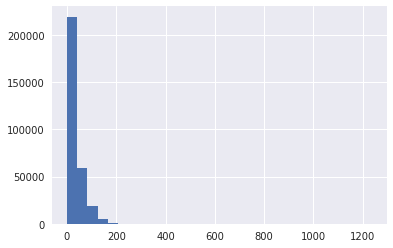

In [141]:
answers_count.hist(bins=30)

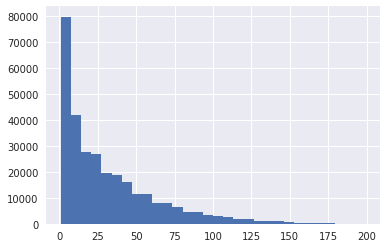

In [142]:
answers_count[answers_count < 200].hist(bins=30)

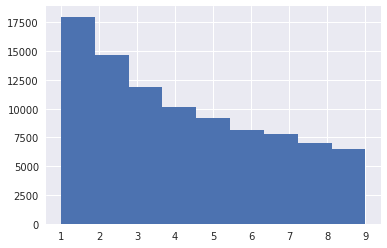

In [143]:
answers_count[answers_count < 10].hist(bins=9)

тут все выглядит ок

# Cколько ответов от одного человека по одному вопросу?

In [116]:
user_answers = personal_events[personal_events.event_type == 'personal_choice'][
    ['user_id', 'interactive_id', 'interactive_item_id', 'created']
].groupby(
    ['user_id', 'interactive_id'], as_index=False
).agg({'interactive_item_id': 'nunique', 'created': 'count'}).rename(columns={
    'created': 'answers_count',
    'interactive_item_id': 'diff_answers_count'
})

In [313]:
user_answers[:3]

,user_id,interactive_id,diff_answers_count,answers_count
0,115,1,1,7
1,12110,7,2,4
2,12110,8,1,1


In [118]:
user_answers[user_answers.diff_answers_count != 1].shape

(718853, 4)

### 718853 ответов потенциально рандомны
### Возможно не все они жулики, может быть со временем у человека меняется отношение к вопросу. Посмотрим на какие вопросы люди чаще меняют ответ?

In [148]:
problem_interactives = user_answers[user_answers.diff_answers_count != 1].\
                        groupby('interactive_id', as_index=False).count().\
                        sort_values(by='answers_count', ascending=False)[['interactive_id', 'answers_count']]

In [155]:
problem_interactives = problem_interactives.merge(interactive, left_on='interactive_id', right_on='id')

In [156]:
problem_interactives[:15]

,interactive_id,answers_count,id,title
0,164,90451,164,Смотрите ли Вы Дом-2. Город любви в 23:00 на канале ТНТ?
1,144,63668,144,Когда вы смотрите развлекательные шоу?
2,233,56827,233,"Если бы завтра Вы пошли в кино, то какой фильм Вы бы предпочли посмотреть?"
3,142,50851,142,Как Вы предпочитаете отдыхать в свободное время?
4,7,47603,7,Как часто Вы посещаете кинотеатры?
5,146,46499,146,На что Вы опираетесь при выборе дизайна своего дома?
6,201,42066,201,Где Вам удобнее смотреть Дом-2?
7,191,39818,191,"К какому типу относится жилье, в котором Вы проживаете?"
8,28,39473,28,Смотрите ли Вы телешоу Дом-2?
9,159,28495,159,Как часто Вы ходите на вечеринки?


# Интересно будет посмотреть, как распределено время между такими ответами. Но наверное в другой раз)

# Сейчас сгруппируем timeserias и представим связанные события [personal_start, personal_choice, personal_success] вместе

In [168]:
# хотя кажется что события personal_success нам пока ненужны

In [166]:
personal_events.user_id.nunique()

303934

In [214]:
personal_events = personal_events[personal_events.event_type.isin(['personal_start', 'personal_choice'])].copy().reset_index(drop=True)

In [215]:
# для удобной сортировки
personal_events['_event_type'] = personal_events.event_type.map({'personal_start': 0, 'personal_choice': 1})

In [217]:
personal_events = personal_events.sort_values(by=['user_id', 'created', '_event_type', ]).reset_index(drop=True)

In [267]:
def shift_start(df):
    # сдвинем время personal_start в строку с personal_choice
    df['start_time'] = df.created.shift(1)
    df['start_user_id'] = df.user_id.shift(1)
    df['start_creative_id'] = df.creative_id.shift(1)
    df['start_interactive_id'] = df.interactive_id.shift(1)
    
    df.rename(columns={'created': 'choise_time'}, inplace=True)

    # оставим только строки с personal_choice
    df = df[df.event_type.isin(['personal_choice'])].copy()
    return df

In [220]:
personal_events = shift_start(personal_events)

In [198]:
personal_events[:10]

,choise_time,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type,start_time,start_user_id,start_creative_id,start_interactive_id
4901,2019-06-17 10:10:21,personal_choice,115,1,1,2,1,2019-06-17 10:10:20,115.0,1.0,1.0
5221,2019-06-17 10:52:16,personal_choice,115,1,1,2,1,2019-06-17 10:52:12,115.0,1.0,1.0
5262,2019-06-17 10:56:38,personal_choice,115,1,1,2,1,2019-06-17 10:56:37,115.0,1.0,1.0
5271,2019-06-17 10:57:21,personal_choice,115,1,1,2,1,2019-06-17 10:57:19,115.0,1.0,1.0
5292,2019-06-17 10:59:49,personal_choice,115,1,1,2,1,2019-06-17 10:57:21,115.0,1.0,1.0
5302,2019-06-17 11:01:06,personal_choice,115,1,1,2,1,2019-06-17 11:01:05,115.0,1.0,1.0
5701,2019-06-17 11:44:08,personal_choice,115,1,1,2,1,2019-06-17 11:44:06,115.0,1.0,1.0
58065,2019-06-18 18:16:43,personal_choice,12110,31,80,344,1,2019-06-18 18:16:35,12110.0,31.0,80.0
247621,2019-06-19 07:49:32,personal_choice,12110,32,109,464,1,2019-06-19 07:49:19,12110.0,32.0,109.0
248689,2019-06-19 07:52:12,personal_choice,12110,15,128,536,1,2019-06-19 07:52:06,12110.0,15.0,128.0


# Теперь у нас в одной строке время начала и время ответа, для каждой сессии пользователя

In [222]:
# проверим что все ок после сдвига:

In [204]:
personal_events[personal_events.creative_id != personal_events.start_creative_id].shape

(1119307, 11)

In [207]:
personal_events[personal_events.interactive_id != personal_events.start_interactive_id].shape

(1090299, 11)

In [209]:
personal_events[personal_events.user_id != personal_events.start_user_id].shape

(17603, 11)

In [221]:
personal_events[
    (personal_events.creative_id != personal_events.start_creative_id) |\
    (personal_events.interactive_id != personal_events.start_interactive_id) |\
    (personal_events.user_id != personal_events.start_user_id)
].shape

(1149582, 11)

In [212]:
1149582 / personal_events.shape[0]

0.1196759329866744

# 12% строк сдвинулись криво. Разберемся почему

## проблемы в сдвиге по user_id

In [225]:
personal_events[personal_events.user_id != personal_events.start_user_id][:10]

,choise_time,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type,start_time,start_user_id,start_creative_id,start_interactive_id
161,2019-07-15 16:07:21,personal_choice,12770,30,164,702,1,2019-07-15 11:11:18,12110.0,44.0,201.0
829,2019-07-12 20:18:49,personal_choice,26760,44,28,97,1,2019-06-25 12:24:04,23983.0,38.0,142.0
1144,2019-06-24 13:50:51,personal_choice,49083,44,28,99,1,2019-07-16 07:11:40,48582.0,4.0,91.0
1730,2019-07-11 17:20:56,personal_choice,72281,41,201,857,1,2019-06-29 08:03:52,59686.0,4.0,90.0
1754,2019-07-13 04:57:28,personal_choice,77840,30,164,702,1,2019-07-06 17:50:06,77159.0,52.0,185.0
2213,2019-06-27 18:08:15,personal_choice,103247,44,164,702,1,2019-07-14 08:17:45,100428.0,54.0,159.0
3554,2019-07-01 16:36:01,personal_choice,223873,44,164,702,1,2019-07-15 18:16:26,222167.0,54.0,159.0
4795,2019-07-16 10:52:09,personal_choice,303815,35,184,781,1,2019-07-14 18:56:48,301631.0,44.0,164.0
5773,2019-06-19 18:17:52,personal_choice,349775,34,80,343,1,2019-07-07 16:44:42,348953.0,4.0,163.0
5987,2019-06-30 19:06:06,personal_choice,361911,50,82,351,1,2019-07-08 22:59:49,357545.0,53.0,191.0


In [226]:
# чтобы сэкономить время, я просто прочитаю df еще раз и повторю несколько преобразований
origin_personal_events = pd.read_csv('LiST/personal_events.csv')

In [230]:
origin_personal_events['_event_type'] = origin_personal_events.event_type.map({'personal_start': 0, 'personal_choice': 1, 'personal_success': 2})

In [231]:
origin_personal_events = origin_personal_events.sort_values(by=['user_id', 'created', '_event_type']).reset_index(drop=True)

In [233]:
# посмотрим откуда ошибка в строке
# 2019-06-24 13:50:51	personal_choice	49083	44	28	99	1	2019-07-16 07:11:40	48582.0	4.0	91.0

In [237]:
origin_personal_events[(origin_personal_events.created == '2019-06-24 13:50:51') & (origin_personal_events.user_id == 49083)]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type
1717,2019-06-24 13:50:51,personal_choice,49083,44,28,99,1


In [238]:
# тут мы видим, что personal_choice пришел раньше чем personal_start
origin_personal_events[1716:1720]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type
1716,2019-07-16 07:11:40,personal_success,48582,4,91,0,2
1717,2019-06-24 13:50:51,personal_choice,49083,44,28,99,1
1718,2019-06-24 13:50:53,personal_start,49083,44,28,0,0
1719,2019-06-24 13:50:57,personal_success,49083,44,28,0,2


In [239]:
# строка с ошибкой
# 2019-07-12 20:18:49	personal_choice	26760	44	28	97	1	2019-06-25 12:24:04	23983.0	38.0	142.0
origin_personal_events[(origin_personal_events.created == '2019-07-12 20:18:49') & (origin_personal_events.user_id == 26760)]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type
1245,2019-07-12 20:18:49,personal_choice,26760,44,28,97,1


In [240]:
# та же история, personal_choice пришел раньше чем personal_start
origin_personal_events[1243:1247]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type
1243,2019-06-25 12:23:56,personal_start,23983,38,142,0,0
1244,2019-06-25 12:24:04,personal_choice,23983,38,142,601,1
1245,2019-07-12 20:18:49,personal_choice,26760,44,28,97,1
1246,2019-07-12 20:18:52,personal_start,26760,44,28,0,0


## проблемы в сдвиге по interactive_id

In [241]:
personal_events[personal_events.interactive_id != personal_events.start_interactive_id][:5]

,choise_time,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type,start_time,start_user_id,start_creative_id,start_interactive_id
28,2019-06-20 07:26:41,personal_choice,12110,36,138,579,1,2019-06-19 14:29:38,12110.0,3.0,81.0
32,2019-06-20 08:22:57,personal_choice,12110,33,82,354,1,2019-06-20 07:27:30,12110.0,36.0,138.0
47,2019-06-23 10:42:53,personal_choice,12110,42,142,602,1,2019-06-23 09:48:21,12110.0,41.0,30.0
54,2019-06-24 08:35:10,personal_choice,12110,1,96,404,1,2019-06-24 07:24:53,12110.0,16.0,115.0
60,2019-06-24 10:21:47,personal_choice,12110,30,126,527,1,2019-06-24 10:11:50,12110.0,15.0,129.0


In [244]:
# строка с ошибкой
# 2019-06-20 07:26:41	personal_choice	12110	36	138	579	1	2019-06-19 14:29:38	12110.0	3.0	81.0
origin_personal_events[(origin_personal_events.created == '2019-06-20 07:26:41') & (origin_personal_events.user_id == 12110)]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type
42,2019-06-20 07:26:41,personal_choice,12110,36,138,579,1


In [247]:
# та же история, события пришли не в том порядке
origin_personal_events[42:45]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type
42,2019-06-20 07:26:41,personal_choice,12110,36,138,579,1
43,2019-06-20 07:26:44,personal_start,12110,36,138,0,0
44,2019-06-20 07:26:47,personal_success,12110,36,138,0,2


# Можно попробовать округлить время и сортировать не только по времени но и по creative_id	interactive_id, это должно снизить колличество ошибок

In [254]:
origin_personal_events['time'] = pd.to_datetime(origin_personal_events.created)

In [264]:
origin_personal_events['rounded_time'] = origin_personal_events.time.dt.round('min')

In [265]:
origin_personal_events[:10]

,created,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type,rounded_time,time
0,2019-06-17 10:10:20,personal_start,115,1,1,0,0,2019-06-17 10:10:00,2019-06-17 10:10:20
1,2019-06-17 10:10:21,personal_choice,115,1,1,2,1,2019-06-17 10:10:00,2019-06-17 10:10:21
2,2019-06-17 10:10:21,personal_success,115,1,1,0,2,2019-06-17 10:10:00,2019-06-17 10:10:21
3,2019-06-17 10:52:12,personal_start,115,1,1,0,0,2019-06-17 10:52:00,2019-06-17 10:52:12
4,2019-06-17 10:52:13,personal_success,115,1,1,0,2,2019-06-17 10:52:00,2019-06-17 10:52:13
5,2019-06-17 10:52:16,personal_choice,115,1,1,2,1,2019-06-17 10:52:00,2019-06-17 10:52:16
6,2019-06-17 10:56:37,personal_start,115,1,1,0,0,2019-06-17 10:57:00,2019-06-17 10:56:37
7,2019-06-17 10:56:38,personal_choice,115,1,1,2,1,2019-06-17 10:57:00,2019-06-17 10:56:38
8,2019-06-17 10:56:39,personal_success,115,1,1,0,2,2019-06-17 10:57:00,2019-06-17 10:56:39
9,2019-06-17 10:57:19,personal_start,115,1,1,0,0,2019-06-17 10:57:00,2019-06-17 10:57:19


In [266]:
personal_events_v2 = origin_personal_events.sort_values(by=['user_id', 'creative_id', 'interactive_id', 'rounded_time', '_event_type']).copy().reset_index(drop=True)

In [268]:
personal_events_v2 = shift_start(personal_events_v2)

In [272]:
bad_shift = personal_events_v2[
    (personal_events_v2.creative_id != personal_events_v2.start_creative_id) |\
    (personal_events_v2.interactive_id != personal_events_v2.start_interactive_id) |\
    (personal_events_v2.user_id != personal_events_v2.start_user_id)
].shape[0]

In [273]:
bad_shift / personal_events_v2.shape[0]

0.010919246525351218

# Колличество криво сдвинутых строк уменьшилось до 1%, думаю их стоит оставить и двигаться дальше

In [276]:
bad_ids = personal_events_v2[
    (personal_events_v2.creative_id != personal_events_v2.start_creative_id) |\
    (personal_events_v2.interactive_id != personal_events_v2.start_interactive_id) |\
    (personal_events_v2.user_id != personal_events_v2.start_user_id)
].index

In [279]:
# убираем кривые строки
personal_events_v2 = personal_events_v2[~personal_events_v2.index.isin(bad_ids)].copy()

In [280]:
personal_events_v2[
    (personal_events_v2.creative_id != personal_events_v2.start_creative_id) |\
    (personal_events_v2.interactive_id != personal_events_v2.start_interactive_id) |\
    (personal_events_v2.user_id != personal_events_v2.start_user_id)
].shape[0]

0

# после проверки видим что теперь все ок

# Хотя в планах использовать разницу по времени между событиями... так что возможно эти строки, где personal_choice раньше чем personal_start все равно пойдут в утиль

In [282]:
personal_events_v2[:2]

,choise_time,event_type,user_id,creative_id,interactive_id,interactive_item_id,_event_type,rounded_time,time,start_time,start_user_id,start_creative_id,start_interactive_id
1,2019-06-17 10:10:21,personal_choice,115,1,1,2,1,2019-06-17 10:10:00,2019-06-17 10:10:21,2019-06-17 10:10:20,115.0,1.0,1.0
4,2019-06-17 10:52:16,personal_choice,115,1,1,2,1,2019-06-17 10:52:00,2019-06-17 10:52:16,2019-06-17 10:52:12,115.0,1.0,1.0


In [284]:
personal_events_v2.columns

Index(['choise_time', 'event_type', 'user_id', 'creative_id', 'interactive_id',
       'interactive_item_id', '_event_type', 'rounded_time', 'time',
       'start_time', 'start_user_id', 'start_creative_id',
       'start_interactive_id'],
      dtype='object')

In [286]:
# избавимся от лишних строк
personal_events_v2 = personal_events_v2[['choise_time', 'user_id', 'creative_id', 'interactive_id', 'interactive_item_id', 'start_time']].copy()

In [287]:
personal_events_v2.choise_time = pd.to_datetime(personal_events_v2.choise_time)
personal_events_v2.start_time = pd.to_datetime(personal_events_v2.start_time)

In [296]:
personal_events_v2['time_diff'] = (personal_events_v2.choise_time - personal_events_v2.start_time) / np.timedelta64(1,'s')

In [299]:
personal_events_v2.time_diff.describe()

count    9.500903e+06
mean     1.424116e+03
std      3.551860e+04
min     -5.800000e+01
25%      3.000000e+00
50%      7.000000e+00
75%      1.200000e+01
max      5.591123e+06
Name: time_diff, dtype: float64

In [305]:
personal_events_v2[personal_events_v2.time_diff > 60*60*24].shape

(28063, 7)

# 28063 записей с разницей больше дня. Могли люди оставить вкладку в браузере открытой?

# По идее на странице должно трекаться поведение пользователей, так что скорее всего все это можно выяснить и провалидировать

# Так что сейчас я выкину из рассмотрения аномалии с 0 < time_diff < 60*1

In [341]:
personal_events_v3 = personal_events_v2[personal_events_v2.time_diff.between(0, 60 * 1)].copy()

In [342]:
personal_events_v2.shape, personal_events_v3.shape

((9500903, 7), (8385536, 7))

In [333]:
personal_events_v3[:3]

,choise_time,user_id,creative_id,interactive_id,interactive_item_id,start_time,time_diff
1,2019-06-17 10:10:21,115,1,1,2,2019-06-17 10:10:20,1.0
4,2019-06-17 10:52:16,115,1,1,2,2019-06-17 10:52:12,4.0
9,2019-06-17 10:57:21,115,1,1,2,2019-06-17 10:56:38,43.0


In [334]:
user_answers[:3]

,user_id,interactive_id,diff_answers_count,answers_count
0,115,1,1,7
1,12110,7,2,4
2,12110,8,1,1


# Сейчас я хочу посмотреть на распределение времени ответа тех, кто отвечал больше 2-х раз на один вопрос и давал разные ответы

In [343]:
suspect_guys = user_answers[user_answers.diff_answers_count > 3].user_id.unique()   
suspect_guys.shape

(25402,)

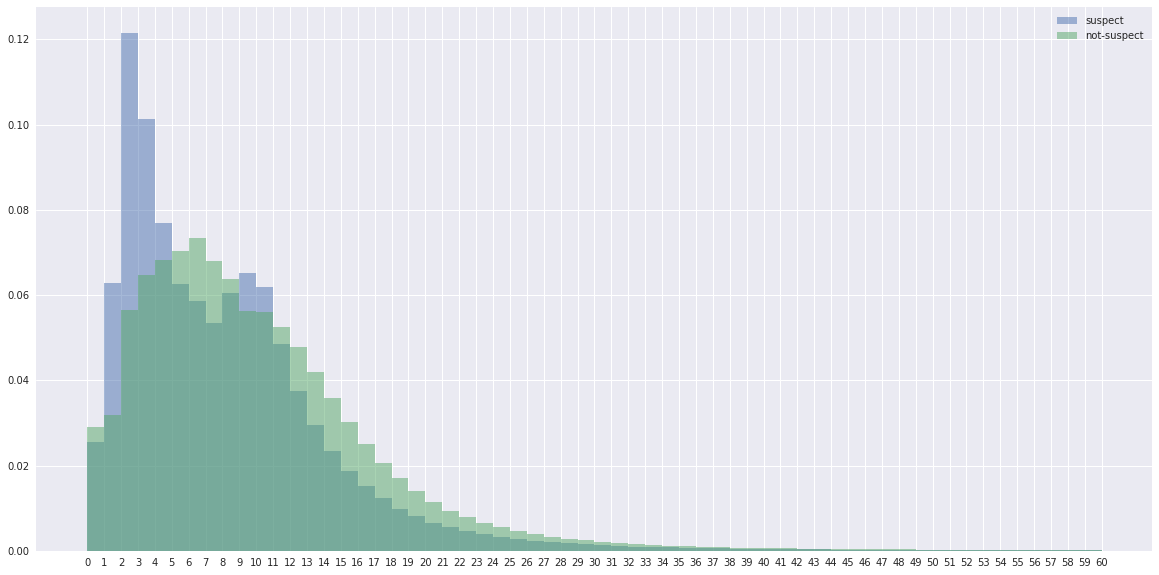

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.hist(personal_events_v3[personal_events_v3.user_id.isin(suspect_guys)].time_diff, alpha=0.5, density=True, label='suspect', bins=60)
ax.hist(personal_events_v3[~personal_events_v3.user_id.isin(suspect_guys)].time_diff, alpha=0.5, density=True, label='not-suspect', bins=60)
ax.set(xticks=range(0, 61))
ax.legend();

# Разница в распределении подтверждает интуицию о скорости рандомного ответа

In [390]:
user_features = personal_events_v3[['user_id', 'time_diff']].groupby('user_id', as_index=False).mean()

In [391]:
user_features['is_suspect'] = user_features.user_id.isin(suspect_guys).astype(int)

In [392]:
# for s, e in [(0, 1), (2, 3), (4, 5), (6, 8), (9, 13), (14, 60)]:
#     user_features['time_{}_{}'.format(s, e)] = ((user_features.time_diff >= s) & ((user_features.time_diff <= e))).astype(int)

In [393]:
user_features[:2]

,user_id,time_diff,is_suspect
0,115,10.200000,0
1,12110,4.490909,1


# Возможно стоит разбить время на бинарные признаки, 0-1, 2-4, 5-10, >10. Но пока не буду.

# Добавлю в user_features инфу о колличествах ответов

In [399]:
user_features = user_features.merge(
    user_answers[['user_id', 'diff_answers_count', 'answers_count']].groupby('user_id', as_index=False).sum()
)

In [405]:
user_features['part_of_counts'] = user_features.diff_answers_count / user_features.answers_count

In [413]:
# напомню:
# answers_count - колличество пройденых опросов
# diff_answers_count - сколько раз, проходя один и тот же опрос человек отвечал по разному

user_features[:2]

,user_id,time_diff,is_suspect,diff_answers_count,answers_count,part_of_counts
0,115,10.200000,0,1,7,0.142857
1,12110,4.490909,1,60,75,0.800000


# Есть интуиция по поводу того, что паттерны рандомных ответов отличаются от не рандомных. Если это так, то нам будет проще находить тех кто ответил рандомно один раз. 
# Возможно люди жмут на первый кнопку или на самую длинну фразу или еще как-то. Рассмотрим их:

In [414]:
user_answers[:1]

,user_id,interactive_id,diff_answers_count,answers_count
0,115,1,1,7


In [415]:
user_answers[user_answers.diff_answers_count > 2].interactive_id.value_counts()[:5]

164    32687
144    20460
233    17569
7      11304
201    11271
Name: interactive_id, dtype: int64

In [416]:
# Возьмем интерактив 7      11304, вопрос про кинотеатры

In [417]:
cinema = personal_events_v3[personal_events_v3.interactive_id == 7]

In [418]:
personal_events_v3[:1]

,choise_time,user_id,creative_id,interactive_id,interactive_item_id,start_time,time_diff
1,2019-06-17 10:10:21,115,1,1,2,2019-06-17 10:10:20,1.0


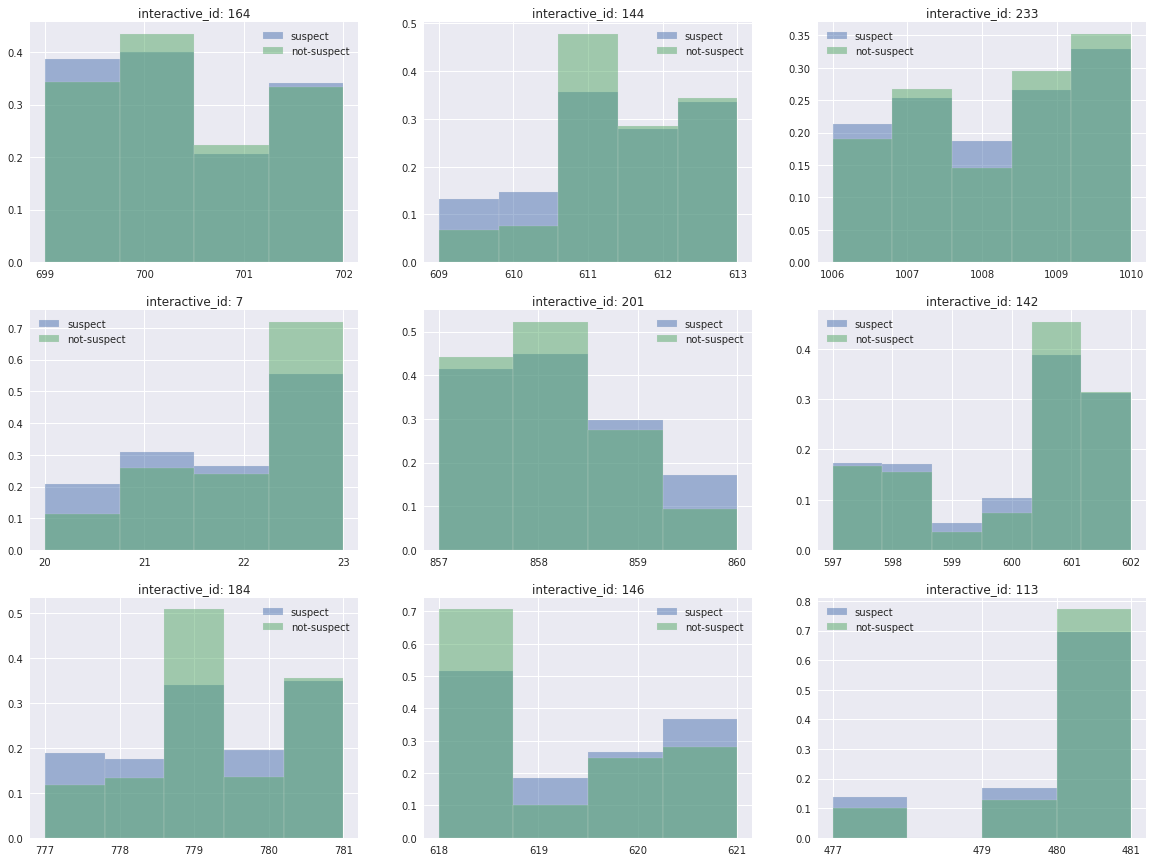

In [453]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15)) 
interactive_ids = user_answers[user_answers.diff_answers_count > 2].interactive_id.value_counts().index

for i, ax in enumerate(axs.flat):
    
    interactive_id = interactive_ids[i]
    df = personal_events_v3[personal_events_v3.interactive_id == interactive_id]
    
    nbins = df.interactive_item_id.nunique()
    
    ax.hist(df[df.user_id.isin(suspect_guys)].interactive_item_id, alpha=0.5, density=True, label='suspect', edgecolor='#E6E6E6', bins=nbins)
    ax.hist(df[~df.user_id.isin(suspect_guys)].interactive_item_id, alpha=0.5, density=True, label='not-suspect', edgecolor='#E6E6E6', bins=nbins)

    ax.set(xticks=df.interactive_item_id.unique())
    ax.set(title='interactive_id: {}'.format(interactive_id))
    ax.legend();


# Попробую использовать для разделения скорость ответа. До 2-х секунд и больше

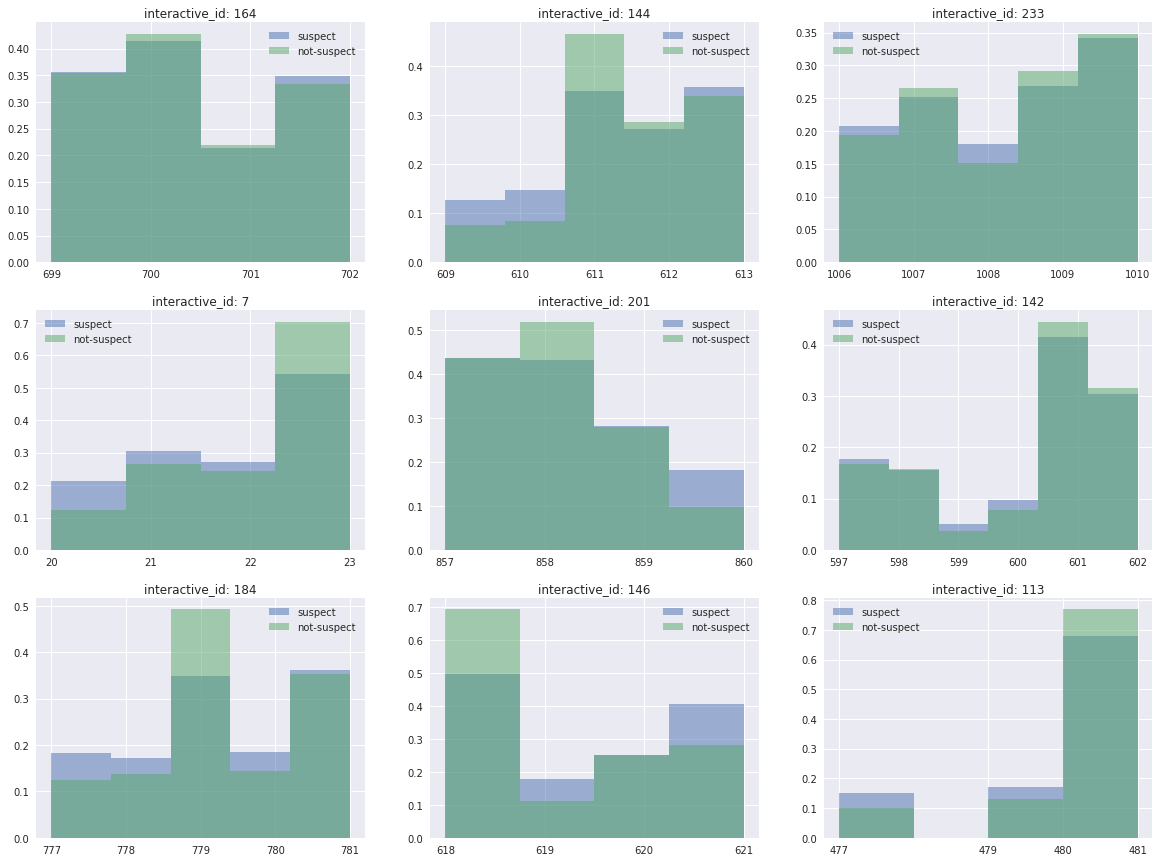

In [452]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15)) 
interactive_ids = user_answers[user_answers.diff_answers_count > 2].interactive_id.value_counts().index

for i, ax in enumerate(axs.flat):
    
    interactive_id = interactive_ids[i]
    df = personal_events_v3[personal_events_v3.interactive_id == interactive_id]
    
    nbins = df.interactive_item_id.nunique()
    
    border = 2
    ax.hist(df[df.time_diff <= border].interactive_item_id, alpha=0.5, density=True, label='suspect', bins=nbins)
    ax.hist(df[df.time_diff > border].interactive_item_id, alpha=0.5, density=True, label='not-suspect', bins=nbins)

    ax.set(xticks=df.interactive_item_id.unique())
    ax.set(title='interactive_id: {}'.format(interactive_id))
    ax.legend();


# Совмещу, посмотрю на респределение ответов для тех кто не входит в число подрозрительных и отвечает долго, против тех кто входит и отвечает быстро:

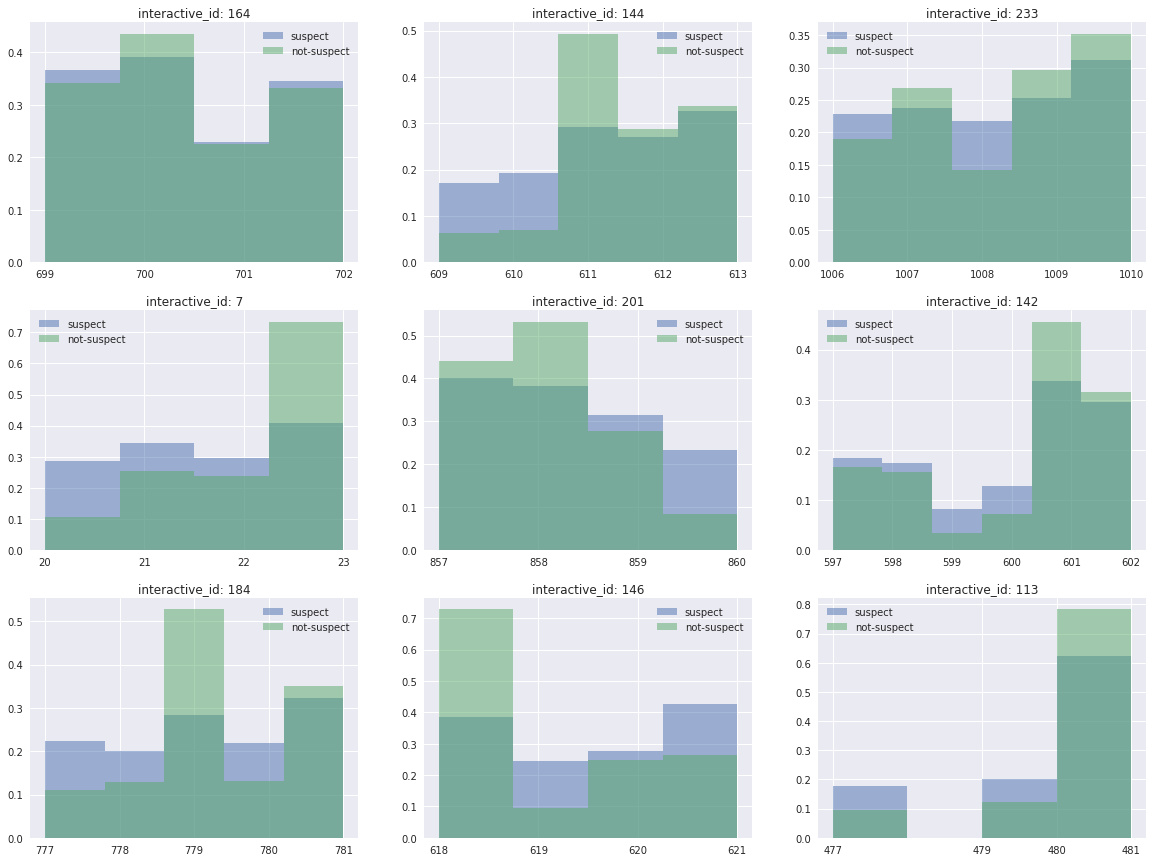

In [459]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15)) 
interactive_ids = user_answers[user_answers.diff_answers_count > 2].interactive_id.value_counts().index

for i, ax in enumerate(axs.flat):
    
    interactive_id = interactive_ids[i]
    df = personal_events_v3[personal_events_v3.interactive_id == interactive_id]
    
    nbins = df.interactive_item_id.nunique()
    
    border = 2
    ax.hist(df[(df.time_diff <= border) & (df.user_id.isin(suspect_guys))].interactive_item_id, alpha=0.5, density=True, label='suspect', bins=nbins)
    ax.hist(df[(df.time_diff > border) & (~df.user_id.isin(suspect_guys))].interactive_item_id, alpha=0.5, density=True, label='not-suspect', bins=nbins)

    ax.set(xticks=df.interactive_item_id.unique())
    ax.set(title='interactive_id: {}'.format(interactive_id))
    ax.legend();


# Возможно что рандомные ответы наоборот распределены равномернее, в отличии от не рандомных?

# Как признак можно выбрать 1 или 2 самых популярных долгих ответа от тех, кто не входит в число подозрительных людей и сравнивать ответ с ними

In [460]:
cinema = personal_events_v3[personal_events_v3.interactive_id == 7]

In [466]:
cinema[:2]

,choise_time,user_id,creative_id,interactive_id,interactive_item_id,start_time,time_diff
70,2019-06-27 09:44:16,12110,16,7,20,2019-06-27 09:44:14,2.0
76,2019-07-07 09:23:16,12110,16,7,22,2019-07-07 09:23:14,2.0


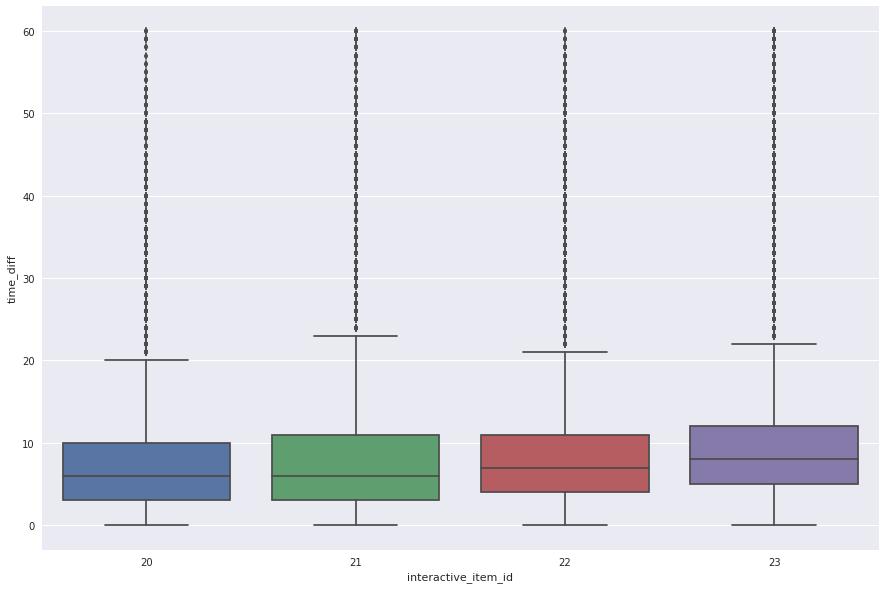

In [472]:
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.boxplot(data=cinema, y='time_diff', x='interactive_item_id', ax=ax);

In [473]:
personal_events_v3[:2]

,choise_time,user_id,creative_id,interactive_id,interactive_item_id,start_time,time_diff
1,2019-06-17 10:10:21,115,1,1,2,2019-06-17 10:10:20,1.0
4,2019-06-17 10:52:16,115,1,1,2,2019-06-17 10:52:12,4.0


In [493]:
# в качестве медленного ответа возьму 4 секунды
sec = 4
most_popular_slowly_answer = personal_events_v3[personal_events_v3.time_diff >= sec][['interactive_id', 'interactive_item_id', 'choise_time']].\
    groupby(['interactive_id', 'interactive_item_id'], as_index=False).\
    count().sort_values(by=['interactive_id', 'interactive_item_id'])
most_popular_slowly_answer[:10]

,interactive_id,interactive_item_id,choise_time
0,1,2,2
1,7,20,19997
2,7,21,44785
3,7,22,41715
4,7,23,126207
5,8,24,719
6,8,25,919
7,8,26,608
8,8,27,3063
9,28,96,170845


In [494]:
answers_stat = {}
for ind, row in most_popular_slowly_answer.iterrows():
    if row.interactive_id not in answers_stat:
        answers_stat[row.interactive_id] = {'interactive_id': row.interactive_id, 'interactive_item_id': row.interactive_item_id, 'choise_time': row.choise_time}
    if answers_stat[row.interactive_id]['choise_time'] < row.choise_time:
        answers_stat[row.interactive_id] = {'interactive_id': row.interactive_id, 'interactive_item_id': row.interactive_item_id, 'choise_time': row.choise_time}

In [500]:
personal_events_v3['is_popular_answer'] = personal_events_v3.apply(
    lambda row: answers_stat[row.interactive_id]['interactive_item_id'] == row.interactive_item_id, axis=1
).astype(int)

In [503]:
answers = personal_events_v3.groupby('user_id', as_index=False).agg({'is_popular_answer': np.sum, 'choise_time': 'count'})

In [505]:
answers['popular_part'] = answers.is_popular_answer / answers.choise_time

# Важно: скорее всего паттерны ответов проявят себя гораздо лучше, если брать во внимание контент который они сопровождают. Но делать это в рамках тетсового задания  уже не буду

In [508]:
user_features = user_features.merge(answers)

In [515]:
user_features[:2]

,user_id,time_diff,is_suspect,diff_answers_count,answers_count,part_of_counts,is_popular_answer,choise_time,popular_part
0,115,10.200000,0,1,7,0.142857,5,5,1.000000
1,12110,4.490909,1,60,75,0.800000,10,55,0.181818


In [540]:
user_features.to_csv('LiST/user_features.csv')

In [656]:
_user_features = user_features.sample(frac=0.01).copy()

In [650]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.cluster import SpectralClustering 

np.random.seed(42)

def clustering(df, drop_columns):
    X = df.drop(columns=drop_columns).values
    for i in range(X.shape[1]):
        X[:, i] = (X[:, i] - X[:, i].mean()) / (X[:, i].max() - X[:, i].min())
        
    # попробуем кластеризовать без колонки is_suspect
    model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans', n_jobs=24)
    labels = model.fit_predict(X)
    
    return X, labels

def show(X, labels):
    pca = PCA(n_components=2).fit_transform(X)
    plt.scatter(pca[:, 0], pca[:, 1], c=labels, edgecolor='black', s=20, cmap='viridis');
    plt.title('PCA')
    plt.show()
    
    tsne = TSNE(n_components=2).fit_transform(X)
    plt.title('TSNE')
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, edgecolor='black', s=20, cmap='viridis');

/bin/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


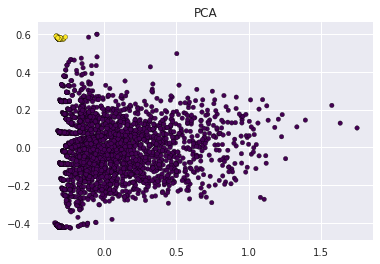

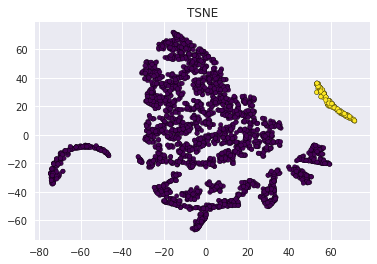

In [664]:
_user_features = user_features.sample(frac=0.01).copy()
X, labels = clustering(_user_features, drop_columns=['user_id', 'is_suspect'])

show(X, labels)

In [668]:
_user_features['label'] = labels

In [665]:
_user_features.is_suspect.value_counts()

0    2759
1     253
Name: is_suspect, dtype: int64

In [666]:
pd.value_counts(labels)

0    2865
1     147
dtype: int64

# Какие фичи использовались?

In [670]:
_user_features[:3]

,user_id,time_diff,is_suspect,diff_answers_count,answers_count,part_of_counts,is_popular_answer,choise_time,popular_part,label
278811,6998435,15.714286,0,20,22,0.909091,7,21,0.333333,0
224724,6818325,8.333333,0,3,3,1.000000,2,3,0.666667,0
73747,6571182,6.086957,0,46,56,0.821429,23,46,0.500000,0


# Попробую убрать ту часть пользователей, где есть инфа о том что человек отвечал по разному на один и тот же вопрос

In [630]:
_user_features.columns

Index(['user_id', 'time_diff', 'is_suspect', 'diff_answers_count',
       'answers_count', 'part_of_counts', 'is_popular_answer', 'choise_time',
       'popular_part', 'label'],
      dtype='object')

In [640]:
# добавим больше данных

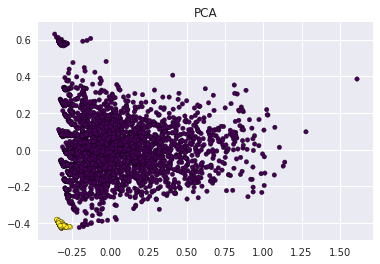

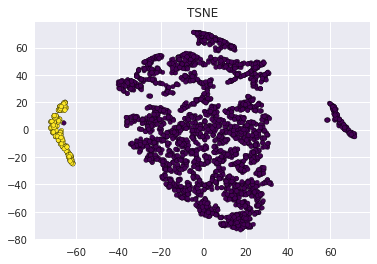

In [678]:
_user_features = user_features.sample(frac=0.01).copy()
X, labels = clustering(
    _user_features, 
    drop_columns=['user_id', 'is_suspect',]
)
_user_features['label'] = labels
show(X, labels)

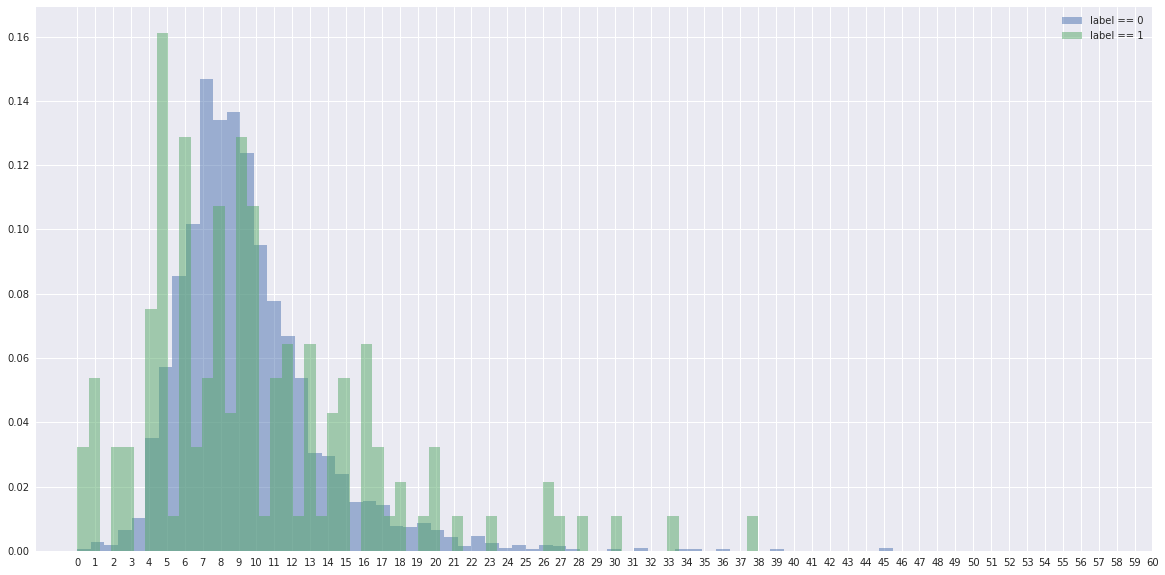

In [672]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.hist(_user_features[_user_features.label == 0].time_diff, alpha=0.5, density=True, label='label == 0', bins=60)
ax.hist(_user_features[_user_features.label == 1].time_diff, alpha=0.5, density=True, label='label == 1', bins=60)
ax.set(xticks=range(0, 61))
ax.legend();

# Итоги:
1. Обязательно надо выбирать фичи с учетом креативов (сейчас учитывалсь только interactive_id)
2. Скорее всего хорошо зайдет трекинг со страницы (движения мыши и тд)
2. Фильтрацию возможного рандома начал бы с времени ответа и его "типичности" с учетом креатива, который человек смотрит
2. Я бы дополнительно рассмотрел полученные кластеры на рисунках выше.
3. Попробовал кластеризацию с большим числом кластеров / другие алгоритмы кластеризации
